In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
titanic=pd.read_csv('train.csv')
titanic=titanic.drop('Name',axis=1)


In [110]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [111]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [112]:
temp=titanic
temp.Sex=le.fit_transform(temp.Sex)

In [40]:
temp.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,S,Q,N,Male,Female
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0,0.0,1.0,0.0
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,1.0,0.0,1.0,0.0
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0,0.0,1.0


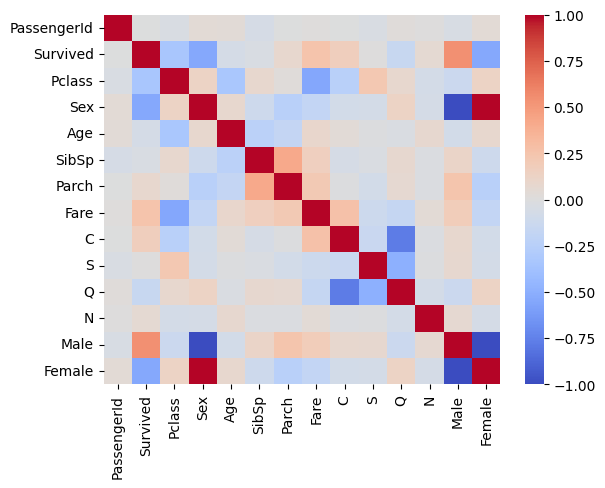

In [42]:
sns.heatmap(titanic.corr(numeric_only=True),cmap="coolwarm")
plt.show()

In [114]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices,test_indices in split.split(titanic,titanic[['Survived','Sex','Pclass']]):
    strat_train_set=titanic.loc[train_indices]
    strat_test_set=titanic.loc[test_indices]
    

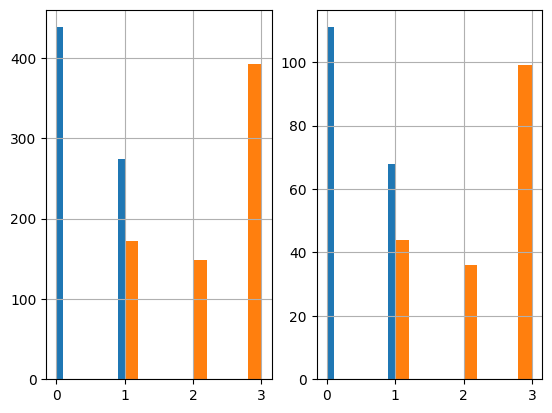

In [115]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()
plt.show()

In [116]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 614 to 872
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    int32  
 4   Age          575 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        162 non-null    object 
 10  Embarked     710 non-null    object 
dtypes: float64(2), int32(1), int64(5), object(3)
memory usage: 64.0+ KB


In [117]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
class AgeImputer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        imputer=SimpleImputer(strategy="mean")
        X['Age']=imputer.fit_transform(X[['Age']])
        return X

In [118]:
from sklearn.preprocessing import OneHotEncoder

class LableChanger(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        encoder=OneHotEncoder()
        matrix=encoder.fit_transform(X[['Embarked']]).toarray()
        column_names=["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix[:,i]
        matrix=encoder.fit_transform(X[['Sex']]).toarray()
        column_names=["Male","Female"]
        for i in range(len(column_names)):
            X[column_names[i]]=matrix[:,i]
        return X

In [119]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(['Embarked','Name','Sex','Ticket','Cabin','N'],axis=1,errors="ignore")

In [120]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline([("ageimputer",AgeImputer()),
                  ("lablechange",LableChanger()),
                  ("featuredropper",FeatureDropper())])

In [121]:
strat_train_set=pipeline.fit_transform(strat_train_set)

In [122]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 614 to 872
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Male         712 non-null    float64
 11  Female       712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [123]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=strat_train_set.drop(['Survived'],axis=1)
y=strat_train_set['Survived']
x_data=scaler.fit_transform(X)
y_data=y.to_numpy()

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
param_grid=[
    {"n_estimators":[10,100,200,500],"max_depth":[5,10,None],"min_samples_split":[2,3,4]}
]
grid_search=GridSearchCV(clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(x_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 10, None],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [125]:
final_clf=grid_search.best_estimator_

In [126]:
final_clf

RandomForestClassifier(min_samples_split=3)

In [127]:
strat_test_set=pipeline.fit_transform(strat_test_set)

In [128]:
x_test=strat_test_set.drop(['Survived'],axis=1)
y_test=strat_test_set['Survived']
scaler=StandardScaler()
x_test=scaler.fit_transform(x_test)
y_test=y_test.to_numpy()

In [129]:
final_clf.score(x_test,y_test)

0.8044692737430168

In [130]:
fin_data=pipeline.fit_transform(titanic)

In [131]:
fin_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Male,Female
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [132]:
x_fin=fin_data.drop(['Survived'],axis=1)
y_fin=fin_data['Survived']
scaler=StandardScaler()
x_fin=scaler.fit_transform(x_fin)
y_fin=y_fin.to_numpy()

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
fin_clf=RandomForestClassifier()
param_grid=[
    {"n_estimators":[10,100,200,500],"max_depth":[5,10,None],"min_samples_split":[2,3,4]}
]
grid_search=GridSearchCV(fin_clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(x_fin,y_fin)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 10, None],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [144]:
fin_pred=grid_search.best_estimator_

In [145]:
fin_pred

RandomForestClassifier(max_depth=10, min_samples_split=3)

In [146]:
titanic_test=pd.read_csv("test.csv")

In [147]:
titanic_test=pipeline.fit_transform(titanic_test)

In [148]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Male         418 non-null    float64
 10  Female       418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [149]:
x_final_test=titanic_test
x_final_test=x_final_test.fillna(method="ffill")
scaler=StandardScaler()
x_final_test=scaler.fit_transform(x_final_test)

C:\Users\alubi\AppData\Local\Temp\ipykernel_8300\4041175533.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_final_test=x_final_test.fillna(method="ffill")


In [150]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Male         418 non-null    float64
 10  Female       418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [152]:
predictions=fin_pred.predict(x_final_test)

In [154]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [155]:
final_df=pd.DataFrame(titanic_test['PassengerId'])
final_df['Survived']=predictions
final_df.to_csv("predictions.csv",index=False)

In [156]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
